# SASA MultiTaskRegressor With Extended Trees Regressor

In [0]:
!apt-get -qq install -y python-rdkit librdkit1 rdkit-data

In [0]:
!pip install -q joblib pandas sklearn tensorflow pillow deepchem

In [0]:
### PUTTING IT ALL TOGETHER
## Requirements involve the 'new.csv' file within the same directory as this 
## notebook is running

## Import Different Modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import io
from sklearn import datasets, svm, metrics, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score
import tempfile
from itertools import islice
from IPython.display import Image, HTML, display
import os
import deepchem as dc
import copy
from sklearn import preprocessing
import numpy as np
from deepchem.utils.evaluate import Evaluator
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
import csv



################################################################
## This is used to search the best number of neighboring base 
##	chemical shift used in this study.
## Number of neighboring pair is set from 0 to 5 (by bash script)
## LOO model
## sklearn: clf = svm.SVC(gamma='auto')
## f1-score is saved under the fold output/seraching_neighbors
################################################################


################################################################
## Read in and pre-process chemical shift data
################################################################

c = pd.read_csv('new.csv', sep=" ")
cs_data = c.rename(columns = {'H8\t' : 'H8'})



################################################################
## Global variables and functions
################################################################
NUMBER_CHEMICAL_SHIFT_TYPE=19


def get_cs_all(cs_all, id):
	'''
	This function gets chemical shifts for a particular RNA.
	'''
	return(cs_all[cs_all.id == id])

def get_cs_residues(cs_i, resid, dummy=0):
	'''
	This function return an array contining the chemical shifts 
	for a particular residues in an RNA.
	'''
	cs_tmp=cs_i[(cs_i.resid == resid)].drop(['id', 'resid', 'resname', 'sasa-All-atoms', 'sasa-Total-Side', 'sasa-Main-Chain', 'sasa-Non-polar', 'sasa-All'], axis=1)
	info_tmp=cs_i[(cs_i.resid == resid)]
	if (cs_tmp.shape[0] != 1):
		return(dummy*np.ones(shape=(1, NUMBER_CHEMICAL_SHIFT_TYPE)))
	else:
		return(cs_tmp.values)

def get_resnames(cs_i, resid, dummy="UNK"):
	'''
	This function returns the residue name for specified residue (resid)
	'''
	cs_tmp=cs_i[(cs_i.resid == resid)]
	if (cs_tmp.shape[0] != 1):
		return(dummy)
	else:
		return(cs_tmp['resname'].values[0])

def get_cs_features(cs_i, resid, neighbors):
	'''
	This function return chemical shifts and resnames for 
	residues (resid) and its neighbors
	'''
	cs=[]
	resnames=[]
	for i in range(resid-neighbors, resid+neighbors+1):
		cs.append(get_cs_residues(cs_i, i))
		resnames.append(get_resnames(cs_i, i))
	return(resnames, np.array(cs))

def get_columns_name(neighbors=3, chemical_shift_types = NUMBER_CHEMICAL_SHIFT_TYPE):
	'''
	Helper function that writes out the required column names
	'''
	#tmp=2*neighbors+1
	#neighbors=1
	columns=['id', 'resname', 'resid', 'sasa-All-atoms', 'sasa-Total-Side', 'sasa-Main-Chain', 'sasa-Non-polar', 'sasa-All']
	for i in range(0, neighbors*NUMBER_CHEMICAL_SHIFT_TYPE):
		columns.append(i)
	return(columns)

def write_out_resname(neighbors=1):
	''' 
	Helper function that writes out the column names associated 
	resnames for a given residue and its neighbors
	'''  
	colnames = []
	for i in range(1-neighbors-1, neighbors+1):
		if i < 0: 
			colnames.append('R%s'%i)
		elif i > 0: 
			colnames.append('R+%s'%i)
		else: 
			colnames.append('R')
	return(colnames)    

def get_cs_features_rna(cs, neighbors=1, retain = ['id', 'sasa-All-atoms', 'sasa-Total-Side', 'sasa-Main-Chain', 'sasa-Non-polar', 'sasa-All', 'resid']):
	'''    
	This function generates the complete required data frame an RNA    
	'''
	all_features = []
	all_resnames = []
	for resid in cs['resid'].unique():
		resnames, features = get_cs_features(cs, resid, neighbors)
		all_features.append(features.flatten())
		all_resnames.append(resnames)

	all_resnames = pd.DataFrame(all_resnames, dtype='object', columns = write_out_resname(neighbors))
	all_features = pd.DataFrame(all_features, dtype='object')
	info = pd.DataFrame(cs[retain].values, dtype='object', columns = retain)
	return(pd.concat([info, all_resnames, all_features], axis=1))

def get_cs_features_rna_all(cs, neighbors):  
	'''    
	This function generate a pandas dataframe containing training data for all RNAs
	Each row in the data frame should contain the class and chemical shifts for given residue and neighbors in a given RNA.
	'''  
	cs_new=pd.DataFrame()
	for pdbid in cs['id'].unique()[0 :]:
		tmp=get_cs_features_rna(get_cs_all(cs, id=pdbid), neighbors)
		cs_new=pd.concat([cs_new, tmp], axis=0)
	return(cs_new)


In [179]:
################################################################
## Build model and test using LOO
################################################################

neighbors=[0,1,2,3,4,5]
R2Dict = {} # Initialize r2 dictionary where key is neighbor and value is a list of lists

# Sets up a loop that iterates through neighbors and then through RNA PDBID's of
# the dataset. This involves the LOO method for different numbers of neighbors. 
# Outputs the r2 scores for each of the tasks and for each of the PDBID for a
# specific neighbor from 0 to 5 as separate .csv files. Ex. '0_neighbors.csv'
for j in neighbors:
  cs_all = get_cs_features_rna_all(cs_data, neighbors=j)
  R2Dict[j] = []
  r2arr = []
  for i in range(len(cs_all['id'].unique())):
    pdbid = cs_all['id'].unique()[i] # Define pdb ID to include in test set and exclude in training set
    test = cs_all[cs_all.id == pdbid]

    train = cs_all[cs_all.id != pdbid]
    train['resid'] = list(range(train.shape[0]))

    ## Create list of user specified features from the modified pd df containing neighbor cs data
    user_specified_features = copy.deepcopy(list(test.columns[-1*(1+2*j)*19:]))


    ### CONSTRUCT SETS
    tasks = ['sasa-All-atoms', 'sasa-Total-Side','sasa-Main-Chain','sasa-Non-polar','sasa-All']
    # tasks = ['sasa-All-atoms']
    train_dataset_X = train[user_specified_features].values
    if len(tasks) == 1:
      train_dataset_y = train[tasks].values.flatten()
    else:
      train_dataset_y = train[tasks].values


    test_dataset_X = test[user_specified_features].values
    if len(tasks) == 1:
      test_dataset_y = test[tasks].values.flatten()
    else:
      test_dataset_y = test[tasks].values

    ## Normalize feature matrix
    train_dataset_X = preprocessing.normalize(train_dataset_X)
    test_dataset_X = preprocessing.normalize(test_dataset_X)
    

    ## Create Extra Trees Regressor Model for Multiple Outputs
    ## Here, we are using the MultiOutputRegressor method in sklearn.multioutput
    ## in order to use a regressor model that can only be used for one single
    ## output. 
    regr = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=100, max_features='sqrt'))
    

    ## Fit the training data
    regr.fit(train_dataset_X,train_dataset_y)

    ## Predict test set data
    y_pred = regr.predict(test_dataset_X)

    ## Get R2 scores for each task
    R2list = []
    for t in range(test_dataset_y.shape[1]):
      R2list.append(r2_score(test_dataset_y.T[t],y_pred.T[t]))
    R2Dict[j].append(np.array(R2list))

  R2Dict[j] = np.asarray(R2Dict[j])
  ds = pd.DataFrame({tasks[0]: R2Dict[j][:,0],tasks[1]: R2Dict[j][:,1], tasks[2]: R2Dict[j][:,2], tasks[3]: R2Dict[j][:,3], tasks[4]: R2Dict[j][:,4]})
  ds.to_csv(str(j)+"_neighbors.csv")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyboardInterrupt: ignored

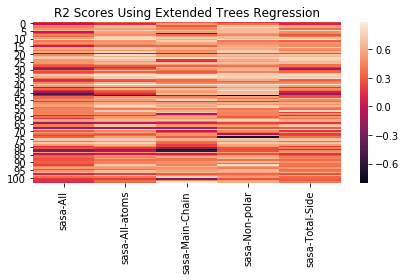

In [180]:
# Get Representative Heatmap of R2 Scores of Predictions from
# Extended Trees Regressor
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

nnn=2

df = pd.read_csv(str(nnn)+'_neighbors.csv')
df = df.drop(df.columns[0],axis=1)

# plot heatmap
ax = sns.heatmap(df)

# turn the axis label
for item in ax.get_yticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(90)

# save figure
plt.title("R2 Scores Using Extended Trees Regression")
plt.tight_layout()
plt.savefig('etreesr2scores.png')
plt.show()

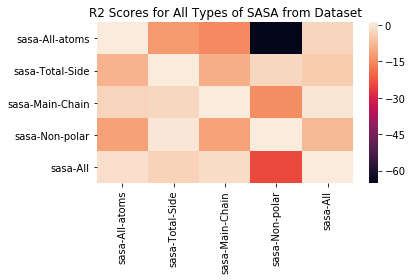

In [181]:
## Get R2 Scores from the Raw Dataset for each permutation of tasks
corrl = []
for l in range(len(tasks)):
  indc = []
  for m in range(len(tasks)):
    indc.append(r2_score(cs_all[tasks[m]],cs_all[tasks[l]]))
  indc = np.asarray(indc)
  corrl.append(indc)
corrl = np.asarray(corrl)

# Convert to Dataframe to plot with Seaborn as a heatmap
corrl = pd.DataFrame(corrl,index=tasks,columns=tasks)

# plot heatmap
ax = sns.heatmap(corrl)

# turn the axis label
for item in ax.get_yticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(90)

# save figure
plt.title("R2 Scores for All Types of SASA from Dataset")
plt.tight_layout()
plt.savefig('rawr2scores.png')
plt.show()

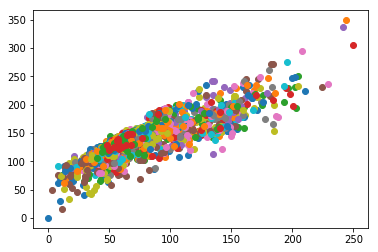

In [182]:
## Looking at the correlation between the different tasks visually across the
## Different types of RNA available in the dataset.
df = pd.DataFrame(dict(x=cs_all[tasks[1]], y=cs_all[tasks[4]], label=cs_all['id']))

groups = df.groupby('label')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x, group.y, marker='.', linestyle='', ms=12, label=name)

plt.show()